<a href="https://colab.research.google.com/github/KanekiCraynet/visi-komputer/blob/main/DETEKSI_DINI_KANKER_SERVIKS_VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DETEKSI DINI KANKER SERVIKS MENGGUNAKAN VGG19 TRANSFER LEARNING

**Tujuan:** Membangun model klasifikasi 5-kelas sel serviks menggunakan VGG19 dengan transfer learning dan fine-tuning pada dataset SIPaKMeD.

**Sumber Data:** Kaggle - SIPaKMeD Dataset

**Metric Evaluasi:** Accuracy, Precision, Recall, F1-score, Confusion Matrix, ROC-AUC, Grad-CAM visualization

## 1. SETUP & REPRODUCIBILITY

In [1]:
# Set random seeds untuk reproducibility
import os
import numpy as np
import tensorflow as tf
import random

# Hyperparameter & Seeds
RANDOM_SEED = 42
BATCH_SIZE = 32
IMG_SIZE = 224  # VGG19 input size
NUM_CLASSES = 5
INITIAL_LR = 1e-4
FINE_TUNE_LR = 1e-5
EPOCHS_PHASE1 = 10  # Initial training (frozen layers)
EPOCHS_PHASE2 = 15  # Fine-tuning

# Set seeds
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"Random Seed: {RANDOM_SEED}")

TensorFlow Version: 2.19.0
GPU Available: []
Random Seed: 42


## 2. INSTALASI LIBRARY

In [2]:
# Install dependencies
!pip install -q kaggle kagglehub opencv-python scikit-learn matplotlib seaborn pillow
print("\n✓ Semua library berhasil diinstal.")


✓ Semua library berhasil diinstal.


## 3. AUTENTIKASI KAGGLE API

In [3]:
import json

# Ganti dengan kredensial Anda
KAGGLE_USERNAME = "phalosanugroho"  # Username Kaggle Anda
KAGGLE_KEY = "KGAT_19e39ef7923129e6677db3ee067df5f0"  # API key dari kaggle.json

# Buat direktori .kaggle
!mkdir -p ~/.kaggle

# Buat kaggle.json
kaggle_credentials = {
    "username": KAGGLE_USERNAME,
    "key": KAGGLE_KEY
}

with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_credentials, f)

# Set permission
!chmod 600 ~/.kaggle/kaggle.json
print("✓ Kaggle API berhasil dikonfigurasi.")

✓ Kaggle API berhasil dikonfigurasi.


## 4. DOWNLOAD DATASET

In [4]:
import kagglehub
import shutil

# Download dataset SIPaKMeD
print("Downloading dataset...")
downloaded_path = kagglehub.dataset_download("prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed")
print(f"\n✓ Dataset berhasil didownload!")
print(f"Path: {downloaded_path}")

100%|██████████| 6.40G/6.40G [01:13<00:00, 93.6MB/s]

Extracting files...



✓ Dataset berhasil didownload!
Path: /root/.cache/kagglehub/datasets/prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed/versions/1


## 5. REORGANISASI DATASET

In [5]:
import cv2
from collections import defaultdict

def reorganize_dataset(source_path, target_path='/tmp/dataset'):
    """
    Reorganisasi dataset SIPaKMeD ke struktur folder per kelas.
    """
    os.makedirs(target_path, exist_ok=True)

    class_mapping = {
        'im_Dyskeratotic': 'Dyskeratotic',
        'im_Koilocytotic': 'Koilocytotic',
        'im_Metaplastic': 'Metaplastic',
        'im_Parabasal': 'Parabasal',
        'im_Superficial-Intermediate': 'Superficial-Intermediate'
    }

    counts = defaultdict(int)

    for root, dirs, files in os.walk(source_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                src_file = os.path.join(root, file)

                # Determine class from folder name
                folder_name = os.path.basename(root)
                target_class = None

                for key, value in class_mapping.items():
                    if key in folder_name or value in folder_name:
                        target_class = value
                        break

                if target_class:
                    class_dir = os.path.join(target_path, target_class)
                    os.makedirs(class_dir, exist_ok=True)

                    dst_file = os.path.join(class_dir, file)
                    if not os.path.exists(dst_file):
                        shutil.copy2(src_file, dst_file)
                        counts[target_class] += 1

    print("\nDataset reorganized:")
    total = 0
    for cls, count in sorted(counts.items()):
        print(f"  {cls}: {count} images")
        total += count
    print(f"  Total: {total} images")

    return target_path

# Reorganize dataset
dataset_path = reorganize_dataset(downloaded_path)
print(f"\n✓ Dataset path: {dataset_path}")


Dataset reorganized:
  Dyskeratotic: 223 images
  Koilocytotic: 238 images
  Metaplastic: 271 images
  Parabasal: 108 images
  Superficial-Intermediate: 126 images
  Total: 966 images

✓ Dataset path: /tmp/dataset


## 6. EKSPLORASI DATA

In [6]:
import matplotlib.pyplot as plt

# Hitung jumlah gambar per kelas
class_counts = defaultdict(int)
class_images = defaultdict(list)

for class_dir in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_dir)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                class_counts[class_dir] += 1
                class_images[class_dir].append(os.path.join(class_path, img_file))

# Print statistik
print("="*60)
print("STATISTIK DATASET SIPAKMED")
print("="*60)
total_images = 0
for class_name in sorted(class_counts.keys()):
    count = class_counts[class_name]
    total_images += count
    print(f"{class_name:30s}: {count:4d} gambar")

print("-"*60)
print(f"{'TOTAL':30s}: {total_images:4d} gambar")
print("="*60)

class_names = sorted(list(class_counts.keys()))
print(f"\nNama Kelas: {class_names}")

STATISTIK DATASET SIPAKMED
Dyskeratotic                  :  223 gambar
Koilocytotic                  :  238 gambar
Metaplastic                   :  271 gambar
Parabasal                     :  108 gambar
Superficial-Intermediate      :  126 gambar
------------------------------------------------------------
TOTAL                         :  966 gambar

Nama Kelas: ['Dyskeratotic', 'Koilocytotic', 'Metaplastic', 'Parabasal', 'Superficial-Intermediate']


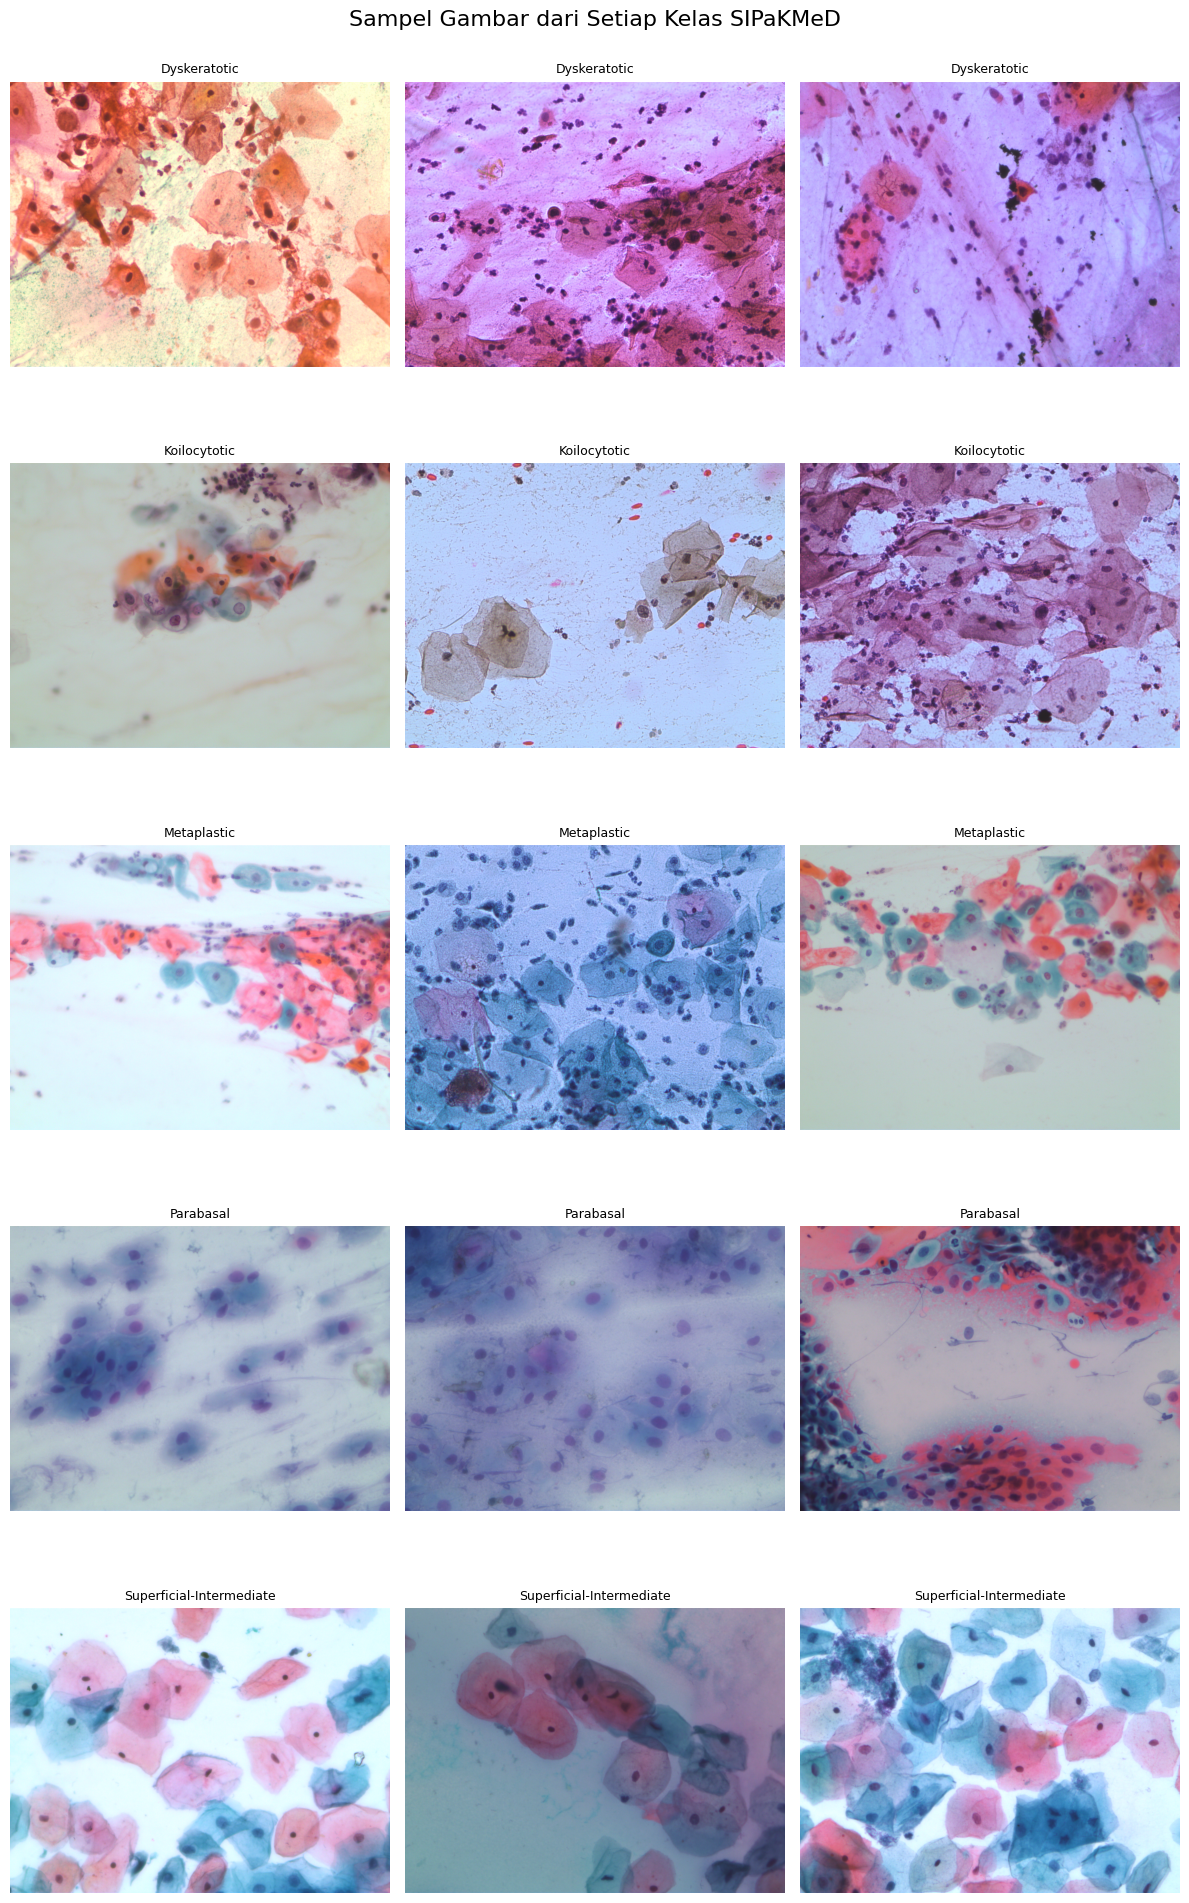

In [7]:
# Visualisasi sampel
fig, axes = plt.subplots(len(class_names), 3, figsize=(12, 4*len(class_names)))
fig.suptitle('Sampel Gambar dari Setiap Kelas SIPaKMeD', fontsize=16)

for idx, class_name in enumerate(class_names):
    sample_images = class_images[class_name][:3]
    for j, img_path in enumerate(sample_images):
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[idx, j].imshow(img)
            axes[idx, j].set_title(f"{class_name}", fontsize=9)
            axes[idx, j].axis('off')

plt.tight_layout()
plt.savefig('/tmp/sample_images.png', dpi=100, bbox_inches='tight')
plt.show()

## 7. PERSIAPAN DATA

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

def load_and_preprocess_image(img_path, target_size=(224, 224)):
    """Load dan preprocess gambar dengan center crop."""
    img = cv2.imread(img_path)
    if img is None:
        return None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Center crop
    h, w = img.shape[:2]
    min_dim = min(h, w)
    y_start = (h - min_dim) // 2
    x_start = (w - min_dim) // 2
    img = img[y_start:y_start + min_dim, x_start:x_start + min_dim]

    img = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
    img = img.astype(np.float32) / 255.0

    return img

# Load semua data
X = []
y_class_idx = []
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

print("Loading data...")
for class_name in class_names:
    class_idx = class_to_idx[class_name]
    img_paths = class_images[class_name]

    for i, img_path in enumerate(img_paths):
        img = load_and_preprocess_image(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        if img is not None:
            X.append(img)
            y_class_idx.append(class_idx)

        if (i + 1) % 500 == 0:
            print(f"  {class_name}: {i+1} gambar diload")

X = np.array(X, dtype=np.float32)
y = np.array(y_class_idx)

print(f"\n✓ Data berhasil diload.")
print(f"  Shape X: {X.shape}")
print(f"  Shape y: {y.shape}")

Loading data...

✓ Data berhasil diload.
  Shape X: (966, 224, 224, 3)
  Shape y: (966,)


In [9]:
# Stratified split: 70% train, 15% val, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=RANDOM_SEED, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15/0.85, random_state=RANDOM_SEED, stratify=y_temp
)

print("STRATIFIED SPLIT:")
print(f"  Train: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Val:   {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test:  {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

# Compute class weights untuk imbalanced data
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print(f"\nClass weights: {class_weight_dict}")

STRATIFIED SPLIT:
  Train: 676 (70.0%)
  Val:   145 (15.0%)
  Test:  145 (15.0%)

Class weights: {0: np.float64(0.8611464968152867), 1: np.float64(0.8144578313253013), 2: np.float64(0.7153439153439154), 3: np.float64(1.7789473684210526), 4: np.float64(1.5363636363636364)}


## 8. DATA AUGMENTATION

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest',
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

# Validation/Test (no augmentation)
val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

# Create generators
train_generator = train_datagen.flow(
    X_train, tf.keras.utils.to_categorical(y_train, NUM_CLASSES),
    batch_size=BATCH_SIZE, shuffle=True
)

val_generator = val_datagen.flow(
    X_val, tf.keras.utils.to_categorical(y_val, NUM_CLASSES),
    batch_size=BATCH_SIZE, shuffle=False
)

test_generator = val_datagen.flow(
    X_test, tf.keras.utils.to_categorical(y_test, NUM_CLASSES),
    batch_size=BATCH_SIZE, shuffle=False
)

print("✓ Data generators created.")
print(f"  Train batches: {len(train_generator)}")
print(f"  Val batches: {len(val_generator)}")

✓ Data generators created.
  Train batches: 22
  Val batches: 5


## 9. BUILD MODEL

In [11]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG19

# Load VGG19 pretrained
base_model = VGG19(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model for Phase 1
base_model.trainable = False

# Build model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', name='fc1'),
    layers.BatchNormalization(name='bn1'),
    layers.Dropout(0.5, name='dropout1'),
    layers.Dense(NUM_CLASSES, activation='softmax', name='classifier')
], name='VGG19_CervicalCancer')

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Count trainable params
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])
print(f"\nTrainable params: {trainable_params:,}")
print(f"Non-trainable params: {non_trainable_params:,}")

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "VGG19_CervicalCancer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,158,021 (76.90 MB)

 Trainable params: 133,125 (520.02 KB)

 Non-trainable params: 20,024,896 (76.39 MB)


Trainable params: 133,125
Non-trainable params: 20,024,896


## 10. PHASE 1: INITIAL TRAINING

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Callbacks
checkpoint = ModelCheckpoint(
    '/tmp/best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

print("PHASE 1: FROZEN BACKBONE")
print("="*50)

history_phase1 = model.fit(
    train_generator,
    epochs=EPOCHS_PHASE1,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stop, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1
)

PHASE 1: FROZEN BACKBONE


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.2202 - loss: 1.6978 
Epoch 1: val_loss improved from inf to 1.71638, saving model to /tmp/best_model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 599s 27s/step - accuracy: 0.2210 - loss: 1.6950 - val_accuracy: 0.2828 - val_loss: 1.7164 - learning_rate: 1.0000e-04
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.2056 - loss: 1.6053 
Epoch 2: val_loss improved from 1.71638 to 1.66257, saving model to /tmp/best_model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 545s 25s/step - accuracy: 0.2060 - loss: 1.6059 - val_accuracy: 0.2828 - val_loss: 1.6626 - learning_rate: 1.0000e-04
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.2111 - loss: 1.6186 
Epoch 3: val_loss improved from 1.66257 to 1.62256, saving model to /tmp/best_model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 555s 25s/step - accuracy: 0.2112 - loss: 1.6188 - val_accuracy: 0.2828 - val_loss: 1.6226 - learning_rate: 1.0000e-04
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20s

## 11. PHASE 2: FINE-TUNING

In [13]:
# Unfreeze Block 4 & 5
unfreeze_from = 10

for layer in base_model.layers[:unfreeze_from]:
    layer.trainable = False
for layer in base_model.layers[unfreeze_from:]:
    layer.trainable = True

# Recompile with smaller LR
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FINE_TUNE_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("PHASE 2: FINE-TUNING")
print("="*50)

history_phase2 = model.fit(
    train_generator,
    epochs=EPOCHS_PHASE2,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stop, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1,
    initial_epoch=len(history_phase1.history['loss'])
)

PHASE 2: FINE-TUNING
Epoch 11/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 43s/step - accuracy: 0.1920 - loss: 1.6273 
Epoch 11: val_loss did not improve from 1.58373
22/22 ━━━━━━━━━━━━━━━━━━━━ 1053s 48s/step - accuracy: 0.1923 - loss: 1.6263 - val_accuracy: 0.2828 - val_loss: 1.6162 - learning_rate: 1.0000e-05
Epoch 12/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 43s/step - accuracy: 0.1861 - loss: 1.6565 
Epoch 12: val_loss did not improve from 1.58373
22/22 ━━━━━━━━━━━━━━━━━━━━ 1051s 48s/step - accuracy: 0.1859 - loss: 1.6548 - val_accuracy: 0.1310 - val_loss: 2.0675 - learning_rate: 1.0000e-05
Epoch 13/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 43s/step - accuracy: 0.2114 - loss: 1.5871 
Epoch 13: val_loss did not improve from 1.58373
22/22 ━━━━━━━━━━━━━━━━━━━━ 1149s 50s/step - accuracy: 0.2101 - loss: 1.5877 - val_accuracy: 0.1310 - val_loss: 2.8486 - learning_rate: 1.0000e-05
Epoch 14/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 43s/step - accuracy: 0.1960 - loss: 1.5865 
Epoch 14: val_loss did not improve from 1.58373

Epoc

## 12. VISUALISASI TRAINING

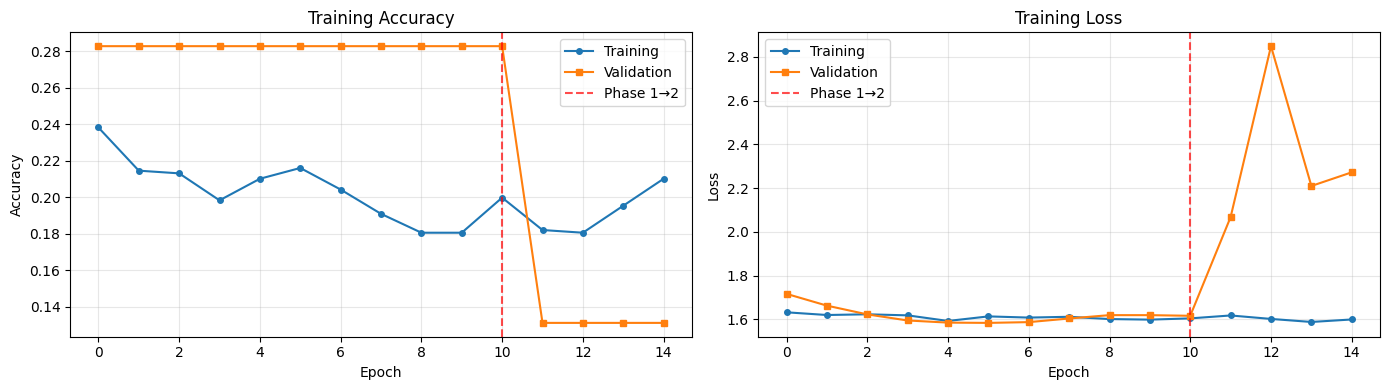

In [14]:
# Combine histories
combined_history = {}
for key in history_phase1.history.keys():
    combined_history[key] = history_phase1.history[key] + history_phase2.history[key]

phase1_epochs = len(history_phase1.history['loss'])

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Accuracy
axes[0].plot(combined_history['accuracy'], label='Training', marker='o', markersize=4)
axes[0].plot(combined_history['val_accuracy'], label='Validation', marker='s', markersize=4)
axes[0].axvline(x=phase1_epochs, color='red', linestyle='--', alpha=0.7, label='Phase 1→2')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Training Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(combined_history['loss'], label='Training', marker='o', markersize=4)
axes[1].plot(combined_history['val_loss'], label='Validation', marker='s', markersize=4)
axes[1].axvline(x=phase1_epochs, color='red', linestyle='--', alpha=0.7, label='Phase 1→2')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Training Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/tmp/training_curves.png', dpi=100)
plt.show()

## 13. EVALUASI MODEL

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

# Preprocess test data
X_test_processed = tf.keras.applications.vgg19.preprocess_input(X_test * 255)

# Evaluasi
test_loss, test_acc = model.evaluate(X_test_processed, tf.keras.utils.to_categorical(y_test, NUM_CLASSES), verbose=0)

# Prediksi
y_pred_proba = model.predict(X_test_processed, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# Metrics
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("="*60)
print("TEST SET EVALUATION")
print("="*60)
print(f"Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("="*60)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

TEST SET EVALUATION
Accuracy:  0.1931 (19.31%)
Precision: 0.1188
Recall:    0.1931
F1-Score:  0.1345

Classification Report:
                          precision    recall  f1-score   support

            Dyskeratotic     0.2273    0.6061    0.3306        33
            Koilocytotic     0.0000    0.0000    0.0000        36
             Metaplastic     0.0909    0.0488    0.0635        41
               Parabasal     0.2353    0.2500    0.2424        16
Superficial-Intermediate     0.1176    0.1053    0.1111        19

                accuracy                         0.1931       145
               macro avg     0.1342    0.2020    0.1495       145
            weighted avg     0.1188    0.1931    0.1345       145



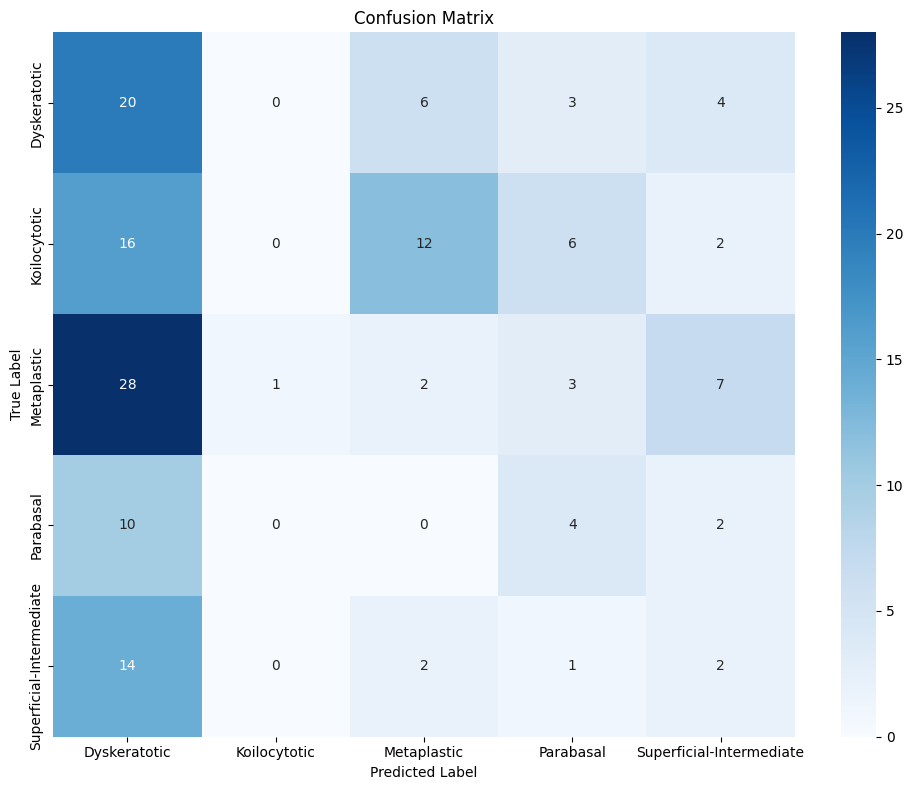

In [16]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')
plt.tight_layout()
plt.savefig('/tmp/confusion_matrix.png', dpi=100)
plt.show()

## 14. ROC-AUC CURVES

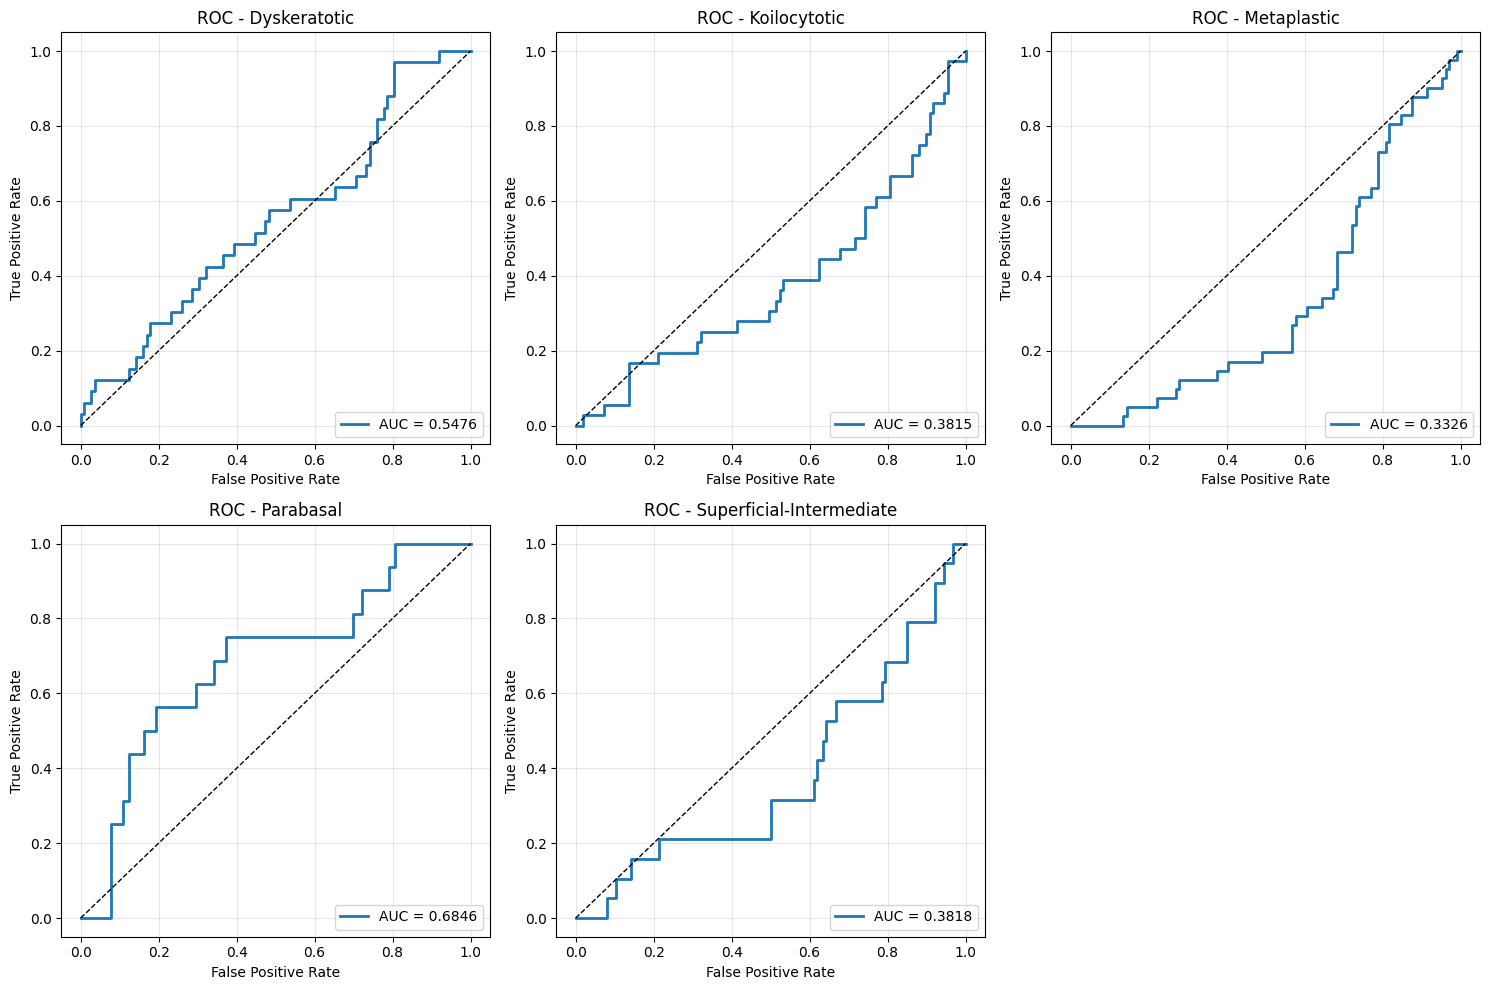

In [17]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score

y_test_bin = label_binarize(y_test, classes=range(NUM_CLASSES))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    auc_score = roc_auc_score(y_test_bin[:, i], y_pred_proba[:, i])

    axes[i].plot(fpr, tpr, lw=2, label=f'AUC = {auc_score:.4f}')
    axes[i].plot([0, 1], [0, 1], 'k--', lw=1)
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title(f'ROC - {class_names[i]}')
    axes[i].legend(loc='lower right')
    axes[i].grid(True, alpha=0.3)

fig.delaxes(axes[5])
plt.tight_layout()
plt.savefig('/tmp/roc_curves.png', dpi=100)
plt.show()

## 15. GRAD-CAM VISUALIZATION

In [23]:
from tensorflow.keras.models import Model

def generate_gradcam(model, img, class_idx, layer_name='block5_conv4'):
    """Generate Grad-CAM heatmap using a rebuilt functional approach."""
    # Preprocess image
    img_processed = tf.keras.applications.vgg19.preprocess_input(img * 255)
    img_batch = np.expand_dims(img_processed, axis=0)

    # Get the base VGG19 model
    base_model = model.layers[0]

    # Get the target conv layer
    conv_layer = base_model.get_layer(layer_name)

    # Create a new model that outputs both conv layer and final predictions
    # Using base_model.input directly (VGG19's input, not Sequential's)
    conv_output_model = Model(inputs=base_model.input, outputs=conv_layer.output)

    with tf.GradientTape() as tape:
        # Get conv layer output
        conv_outputs = conv_output_model(img_batch)
        tape.watch(conv_outputs)

        # Forward pass through remaining layers manually
        x = conv_outputs
        # Continue through remaining VGG19 layers after the conv layer
        found = False
        for layer in base_model.layers:
            if found:
                x = layer(x)
            if layer.name == layer_name:
                found = True

        # Pass through the classifier head (layers after VGG19 in Sequential)
        for layer in model.layers[1:]:
            x = layer(x)

        predictions = x
        loss = predictions[:, class_idx]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap, axis=-1)

    heatmap = tf.nn.relu(heatmap)
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-7)

    return heatmap.numpy()

def overlay_gradcam(img, heatmap):
    """Overlay heatmap on image."""
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_colored = cv2.applyColorMap((heatmap_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted((img * 255).astype(np.uint8), 0.6, heatmap_colored, 0.4, 0)
    return overlay

print("✓ Grad-CAM functions defined.")

✓ Grad-CAM functions defined.


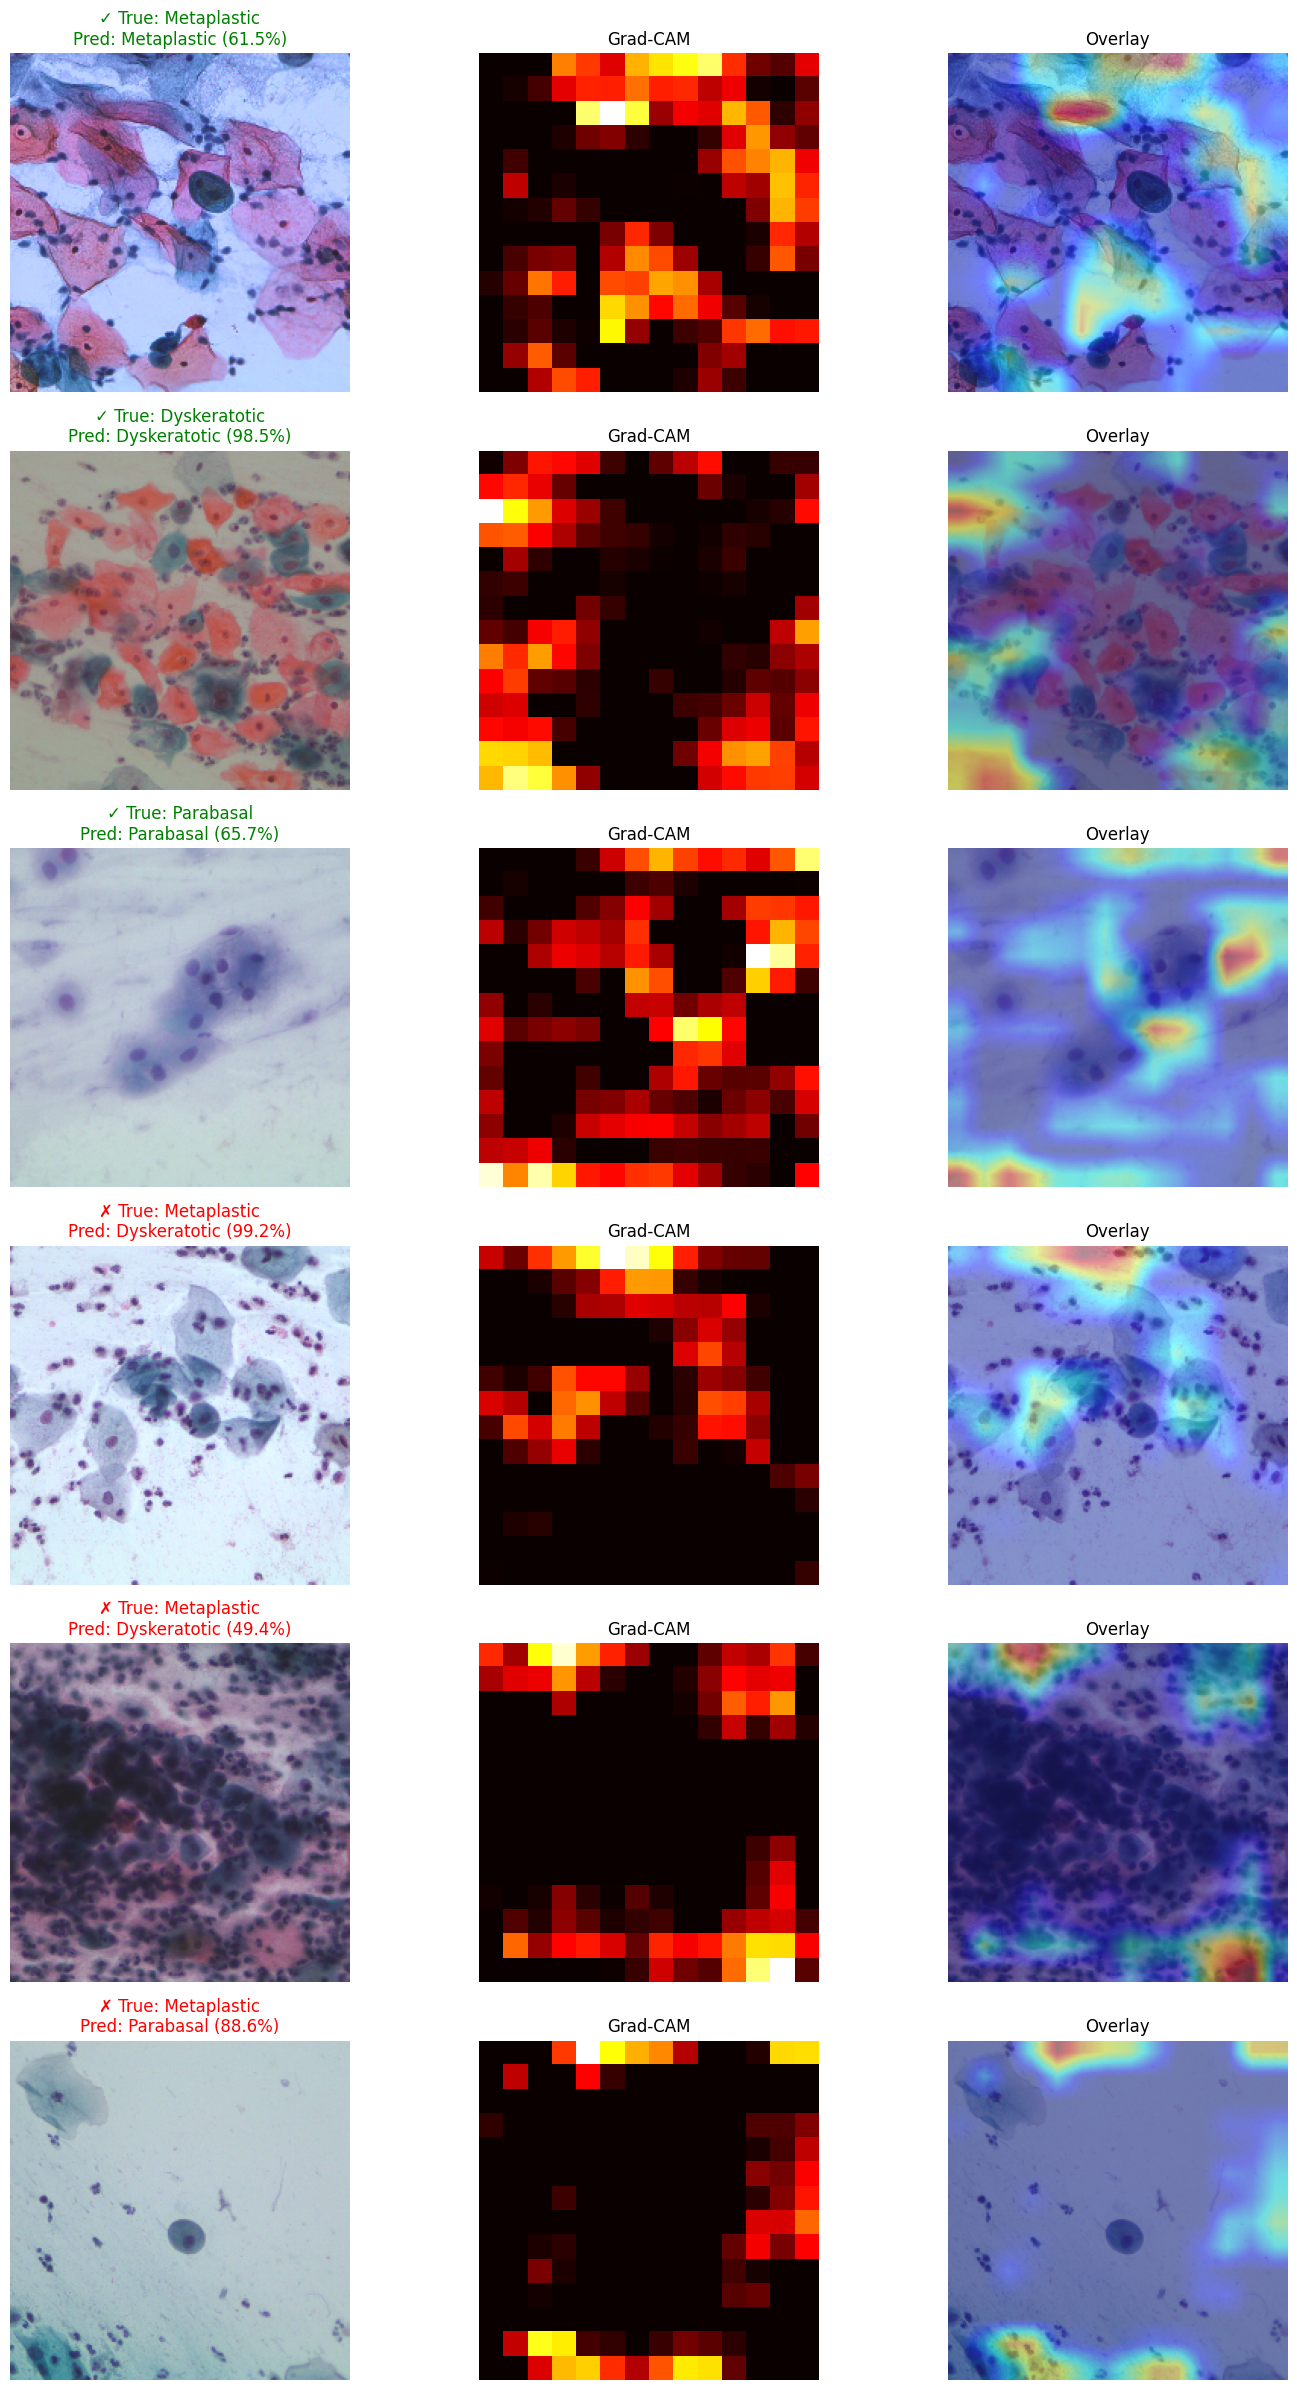

In [24]:
# Select samples
correct_indices = np.where(y_pred == y_test)[0]
incorrect_indices = np.where(y_pred != y_test)[0]

n_correct = min(3, len(correct_indices))
n_incorrect = min(3, len(incorrect_indices))

sample_correct = np.random.choice(correct_indices, size=n_correct, replace=False)
sample_incorrect = np.random.choice(incorrect_indices, size=n_incorrect, replace=False) if len(incorrect_indices) > 0 else []

sample_indices = list(sample_correct) + list(sample_incorrect)

# Plot
fig, axes = plt.subplots(len(sample_indices), 3, figsize=(15, 4*len(sample_indices)))

for plot_idx, sample_idx in enumerate(sample_indices):
    img = X_test[sample_idx]
    true_label = class_names[y_test[sample_idx]]
    pred_label = class_names[y_pred[sample_idx]]
    pred_conf = y_pred_proba[sample_idx].max()

    is_correct = y_pred[sample_idx] == y_test[sample_idx]
    color = 'green' if is_correct else 'red'
    status = '✓' if is_correct else '✗'

    axes[plot_idx, 0].imshow(img)
    axes[plot_idx, 0].set_title(f"{status} True: {true_label}\nPred: {pred_label} ({pred_conf:.1%})", color=color)
    axes[plot_idx, 0].axis('off')

    try:
        heatmap = generate_gradcam(model, img, y_test[sample_idx])
        axes[plot_idx, 1].imshow(heatmap, cmap='hot')
        axes[plot_idx, 1].set_title('Grad-CAM')
        axes[plot_idx, 1].axis('off')

        overlay = overlay_gradcam(img, heatmap)
        axes[plot_idx, 2].imshow(overlay)
        axes[plot_idx, 2].set_title('Overlay')
        axes[plot_idx, 2].axis('off')
    except Exception as e:
        print(f"Error for sample {sample_idx}: {e}")

plt.tight_layout()
plt.savefig('/tmp/gradcam.png', dpi=100)
plt.show()

## 16. SAVE MODEL

In [25]:
import json

# Save model
model.save('/tmp/vgg19_cervical_cancer.keras')
print("✓ Model saved as 'vgg19_cervical_cancer.keras'")

# Save class names
with open('/tmp/class_names.json', 'w') as f:
    json.dump(class_names, f)
print("✓ Class names saved.")

# Summary
print("\n" + "="*60)
print("RINGKASAN EKSPERIMEN")
print("="*60)
print(f"\nDataset: SIPaKMeD ({len(X)} images, {NUM_CLASSES} classes)")
print(f"Model: VGG19 Transfer Learning")
print(f"\nResults:")
print(f"  Accuracy:  {test_acc:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")
print("="*60)

✓ Model saved as 'vgg19_cervical_cancer.keras'
✓ Class names saved.

RINGKASAN EKSPERIMEN

Dataset: SIPaKMeD (966 images, 5 classes)
Model: VGG19 Transfer Learning

Results:
  Accuracy:  0.1931
  Precision: 0.1188
  Recall:    0.1931
  F1-Score:  0.1345
